In [1]:
import xarray
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pycountry

from climada.entity import Exposures
import climada.util.coordinates as u_coord
from climada_petals.engine import SupplyChain

import logging

LOGGER = logging.getLogger()

This notebook shows how to load various geo data as CLIMADA exposure. The geo data represents proxies exposures of the manufacturing, mining, forestry, and agricultural sectors. For mining and forestry, no information regarding the value of the exposed assets is provided. For these cases, we use production values in the IOT tables to disaggregate exposed values.

In [2]:
def get_manufacture_exp(nc_file_path=None, 
                        year=None,
                        countries=None):
    """
    Get manufacturing exposure.

    nc_file_path : str
        local path to IIASA ECLIPSE netcdf file.
    year : int
        year to analyze
    countries : str or list
        countries' ISO3
    """

    data = xarray.open_dataset(nc_file_path)

    data_df = data.sel(time=year)['emis_ind'].to_dataframe().drop(
        columns='time').reset_index().rename(columns = {'lat': 'latitude',
                                                        'lon': 'longitude',
                                                        'emis_ind': 'value'})

    # neglect points with very low emissions
    data_df = data_df[data_df.value > 1]

    if countries:
        # chunk on geographic bounds
        target_geometries = u_coord.get_land_geometry(countries)

        data_df['geometry'] = gpd.points_from_xy(
            x = data_df.longitude,
            y = data_df.latitude
            )
        within_geom = target_geometries.contains(data_df.geometry.values)
        data_df = data_df[within_geom]

    exp = Exposures(data_df)
    exp.set_geometry_points()

    return exp

def get_mining_exp(
                    path_to_folder=None,
                    countries=None,
                    mriot_type='WIOD16',
                    mriot_year=2010,
                    repr_sectors='Mining and quarrying'
                   ):
    """
    Get mining exposure.

    path_to_folder : str
        local path to unzipped USGS folder
    countries : list
        countries' ISO3
    """

    glob_prod, repr_sectors = get_prod_secs(mriot_type, mriot_year, repr_sectors)

    data_df = pd.read_csv(f'{path_to_folder}/deposit.csv', 
                            usecols=[2, 4, 5, 6])

    cnt_dfs = []
    for iso3_cnt in countries:
        cnt_df = data_df[data_df['country'].values == pycountry.countries.get(alpha_3=iso3_cnt).name]
        cnt_df['value'] = 1 / glob_prod.loc[iso3_cnt].loc[repr_sectors].sum().values[0]
        cnt_dfs.append(cnt_df)

    exp = Exposures(pd.concat(cnt_dfs).reset_index(drop=True))
    exp.set_geometry_points()

    return exp

def get_forestry_exp(
                    nc_file_path=None,
                    land_classes=None,
                    countries=None,
                    mriot_type='WIOD16',
                    mriot_year=2010,
                    repr_sectors='Forestry and logging',
                    apply_boundaries = False
                    ):
    """
    Get forestry exposure.

    nc_file_path : str
        local path to COPERNICUS netcdf file.
    land_classes : list of land classes
        land use classes of interest.
        For more info see on the meaning of land use classes
        https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-land-cover?tab=doc
    countries : list
        countries' ISO3
    mriot_type : str
    mriot_year : str
    apply_boundaries : bool
        If only points that actually end up in countries' polygon are selected.
        This makes sure there are no false positives, but substantially increases
        required computation. Default False
    """

    if (len(countries) > 0) | (len(land_classes) > 0):
        LOGGER.warning(
            "Either multiple countries or land use classes were selected. Mind that"
            " this may be too heavy to handle in many cases. If so, try loading individual"
            " countries and classes."
        )

    glob_prod, repr_sectors = get_prod_secs(mriot_type, mriot_year, repr_sectors)

    data = xarray.open_dataset(nc_file_path)

    cnt_dfs = []
    for iso3_cnt in countries:
        print(f'Country {iso3_cnt}')

        target_geometries = u_coord.get_land_geometry(iso3_cnt)
        min_lon, min_lat, max_lon, max_lat = target_geometries.bounds

        if iso3_cnt == 'USA':
            max_lon = -50

        elif iso3_cnt == 'RUS':
            min_lon = 35

        lat_sel = np.where((data.lat > min_lat) & (data.lat < max_lat))[0]
        lon_sel = np.where((data.lon > min_lon) & (data.lon < max_lon))[0]

        data_sel = data.isel(lon=lon_sel, lat=lat_sel, time=0)['lccs_class']

        cnt_df = data_sel.to_dataframe().drop(columns='time'
                ).reset_index().rename(columns = {'lat': 'latitude',
                                                  'lon': 'longitude'})

        lnd_dfs = []
        for lnd_cls in land_classes:
            print(f'Land class {lnd_cls}')

            lnd_df = cnt_df[cnt_df.lccs_class == lnd_cls]

            if apply_boundaries:
                lnd_df['geometry'] = gpd.points_from_xy(
                                x = lnd_df.longitude,
                                y = lnd_df.latitude
                                )
                within_geom = target_geometries.contains(lnd_df.geometry.values)
                lnd_df = lnd_df[within_geom]

            lnd_dfs.append(lnd_df)

        cnt_df = pd.concat(lnd_dfs).reset_index(drop=True)

        try:
            cnt_df['value'] = 1 / glob_prod.loc[iso3_cnt].loc[repr_sectors].sum().values[0]
        except KeyError:
            LOGGER.warning('You are simulating a country for which there are no production data in the chosen IOT')
            cnt_df['value'] = 1 / glob_prod.loc['ROW'].loc[repr_sectors].sum().values[0]

        cnt_dfs.append(cnt_df)

    exp = Exposures(pd.concat(cnt_dfs).reset_index(drop=True))
    exp.set_geometry_points()

    return exp

def get_agro_exp(path_to_folder=None,
                 countries=None):
    """
    Get agriculture exposure.

    path_to_folder : str
        local path to SPAM unzipped folder
    countries : list of countries ISO3
        selection of countries
    """

    data_df = pd.read_csv(f'{path_to_folder}/spam2010V2r0_global_V_agg_TA.csv', encoding='cp1252')

    data_df = data_df[['iso3', 'x', 'y', 'vp_crop_a']].reset_index().rename(
                                                            columns = {'y': 'latitude',
                                                                       'x': 'longitude',
                                                                       'vp_crop_a': 'value'})
    if countries:
        cnt_bools = np.vstack([data_df['iso3'].values == iso3_cnt 
                                for iso3_cnt in countries]).any(0)
        data_df = data_df[cnt_bools]

    exp = Exposures(data_df)
    exp.set_geometry_points()

    return exp

def get_prod_secs(mriot_type, mriot_year, repr_sectors):
    mriot = SupplyChain.from_mriot(mriot_type=mriot_type, 
                                mriot_year=mriot_year).mriot

    if isinstance(repr_sectors, (range, np.ndarray)):
        repr_sectors = mriot.get_sectors()[repr_sectors].tolist()

    elif isinstance(repr_sectors, str):
        repr_sectors = [repr_sectors]
    
    return mriot.x, repr_sectors

In [3]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

/var/folders/3v/hmpf2qbs4ss2ptc1cjx4s3140000gn/T/ipykernel_50077/3744710904.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


# Manufacturing

Data from https://previous.iiasa.ac.at/web/home/research/researchPrograms/air/ECLIPSEv6b.htmland -> NOx emissions

In [4]:
exp = get_manufacture_exp(
    nc_file_path='ECLIPSE_V6b_CLE_base_NOx.nc',
    year=2010,
    countries=['USA', 'FRA']
    )

<Axes: >

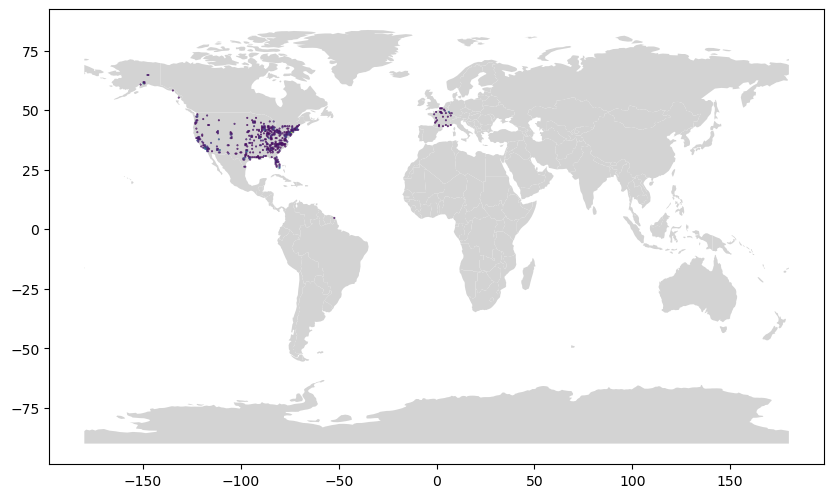

In [5]:
cmap='viridis'
norm=plt.Normalize(vmin=0, vmax=50)

fig, ax = plt.subplots(figsize=(10, 6))
worldmap.plot(color="lightgrey", ax=ax)

exp.gdf.plot(column=exp.gdf['value'], norm=norm, cmap=cmap, ax=ax, markersize=0.2)

# Mining

Data from: https://mrdata.usgs.gov/major-deposits/ -> download and unzip the file *ofr20051294-csv.zip*

In [6]:
exp = get_mining_exp('ofr20051294', countries=['BEL', 'LUX', 'ITA', 'CHN'],
                   mriot_type = 'WIOD16',
                   mriot_year = 2010,
                   repr_sectors = 'Mining and quarrying'
                   )

/Users/aciullo/Documents/GitHub/climada_python/climada/util/coordinates.py:2747: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(


/Users/aciullo/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<Axes: >

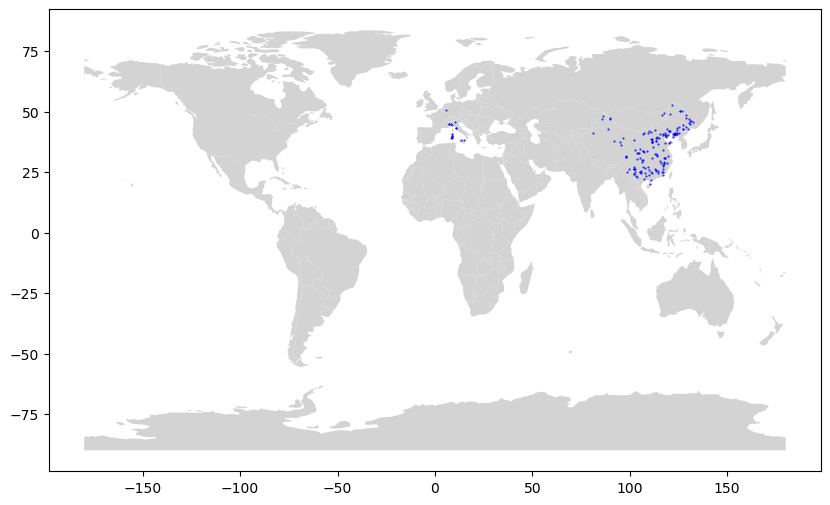

In [7]:
# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(10, 6))
worldmap.plot(color="lightgrey", ax=ax)

exp.gdf.plot(column='value', ax=ax, color="blue", markersize=0.2)

# Forestry

Data from: https://cds.climate.copernicus.eu/cdsapp#!/dataset/10.24381/cds.006f2c9a?tab=overview. Registration needed. After download, unzip folder.

See extra docs https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-land-cover?tab=doc for land use classes codes.

In [8]:
exp = get_forestry_exp('C3S-LC-L4-LCCS-Map-300m-P1Y-2020-v2.1.1.nc', 
                    countries=['COL', 'BRA'],
                    land_classes=[60, 70],
                    mriot_type='WIOD16',
                    mriot_year=2010,
                    repr_sectors='Forestry and logging',
                    apply_boundaries=False
                    )

Country COL


Land class 60
Land class 70
Country BRA
Land class 60
Land class 70


/Users/aciullo/Documents/GitHub/climada_python/climada/util/coordinates.py:2747: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(


/Users/aciullo/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/geopandas/plotting.py:658: UserWarning: Only specify one of 'column' or 'color'. Using 'color'.
  warnings.warn(


<Axes: >

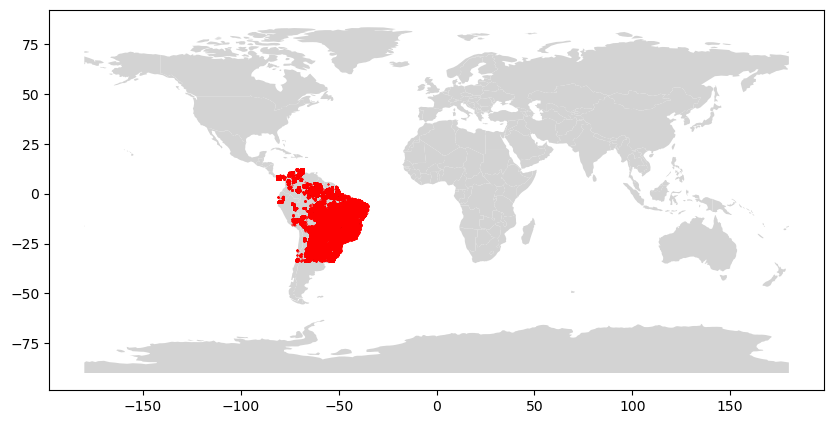

In [9]:
# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(10, 6))
worldmap.plot(color="lightgrey", ax=ax)

#rand_ind = np.random.choice(exp.gdf.index, 100000, replace=False)
exp.gdf.plot(column='value', markersize=0.1, ax=ax, color='red')

# Agriculture

Data from: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/PRFF8V -> download *spam2010v2r0_global_val_prod_agg.csv.zip* (file with production values) 

See supporting publication at https://essd.copernicus.org/articles/12/3545/2020/essd-12-3545-2020.html
and website https://mapspam.info/methodology/ 

In [10]:
exp = get_agro_exp('spam2010v2r0_global_val_prod_agg', countries=['AUS'])

/Users/aciullo/Documents/GitHub/climada_python/climada/util/coordinates.py:2747: FutureWarning: You are adding a column named 'geometry' to a GeoDataFrame constructed without an active geometry column. Currently, this automatically sets the active geometry column to 'geometry' but in the future that will no longer happen. Instead, either provide geometry to the GeoDataFrame constructor (GeoDataFrame(... geometry=GeoSeries()) or use `set_geometry('geometry')` to explicitly set the active geometry column.
  df_val['geometry'] = gpd.GeoSeries(


<Axes: >

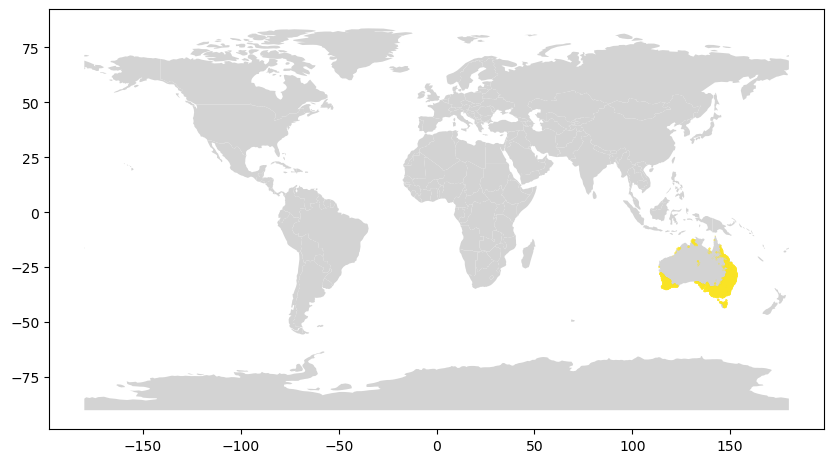

In [13]:
cmap='viridis'
norm=plt.Normalize(vmin=0, vmax=50)

fig, ax = plt.subplots(figsize=(10, 6))
worldmap.plot(color="lightgrey", ax=ax)

exp.gdf.plot(column=exp.gdf['value'], 
            markersize=0.01,
            norm=norm, cmap=cmap, ax=ax)

## Note on Agriculture:

Mind that this is for actute risk assessment (e.g., tropical cyclones or floods). For chronic risk assessment, i.e., if one wants to simulate crop yield losses due to long-term climatic changes, then she should use following CLIMADA module:

https://github.com/CLIMADA-project/climada_petals/blob/main/doc/tutorial/climada_hazard_entity_Crop.ipynb

and use the crop yield simulations from ISIMIP. 

For an understanding of the data check https://protocol.isimip.org/ (select ISIMIP3 and Agriculture)

Reference : https://www.nature.com/articles/s43016-021-00400-y